In [6]:
import matplotlib.pyplot as plt

from pathlib import Path
from lmfit import Parameters
from lmfit import minimize, fit_report

In [7]:
import pyroll.core as pr
import pyroll.pillar_model
import pyroll.neutral_point_estimator
import pyroll.sparling_spreading
import pyroll.hensel_force_torque
import pyroll.freiberg_flow_stress
import pyroll.ring_model_thermal
from pyroll.freiberg_flow_stress import flow_stress

In [8]:
from in_profile import create_in_profile_for_finishing_train
from rolling_sequence import finishing_pass_design_1, finishing_pass_design_2, finishing_pass_design_3
from utilities import *

In [9]:
pyroll.pillar_model.Config.PILLAR_COUNT = 30
pyroll.neutral_point_estimator.Config.ESTIMATOR = "EQUAL"
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

root_dir = Path.cwd()
result_dir = root_dir / "res"

In [10]:
@pr.CoolingPipe.DiskElement.heat_transfer_coefficient
def heat_transfer_coefficient_model_wehage_8_mm(self: pr.CoolingPipe.DiskElement):
    mean_surface_temperature = (self.in_profile.surface_temperature + self.out_profile.surface_temperature) / 2
    profile_surface_temperature_celsius = mean_surface_temperature - 273.15
    return 13950 + 5.12 * 1e6 / profile_surface_temperature_celsius

In [11]:
in_profile = create_in_profile_for_finishing_train(950 + 273.15)
in_profile.ring_temperatures = in_profile.ring_temperatures

In [12]:
rolling_train_rpd1 = finishing_pass_design_1(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd2 = finishing_pass_design_2(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd3 = finishing_pass_design_3(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

In [13]:
rolling_train_rpd1.solve(in_profile)
rolling_train_rpd2.solve(in_profile)
rolling_train_rpd3.solve(in_profile)

Solution iteration of TwoRollPass '23-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '24-V' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '17-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '21-H' exceeded the maximum iteration count of 100. Continuing anyway.


Profile(
    classifiers={'false_round', 'generic_elongation', 'round', 'symmetric'},
    core_temperature=np.float64(1397.7488582923372),
    cross_section=Polygon(
        area=5.82635230991946e-05,
        height=0.008700000000000006,
        perimeter=0.027129052642081364,
        width=0.008249205568719213,
        ),
    length=92.57470831110322,
    material=['BST500', 'steel'],
    ring_temperatures=array([1397.74885829, 1395.25908927, 1387.77992574, 1375.26436486,
           1357.5992688 , 1334.64557682, 1306.53190243, 1274.39348479,
           1241.40247337, 1213.15915741, 1195.80201163]),
    strain=np.float64(0.42927981011537364),
    surface_temperature=np.float64(1195.8020116297703),
    t=np.float64(1.8404522472310272),
    temperature=np.float64(1272.4336229716846),
    weight=2400,
    width=np.float64(0.008249205568719213),
    )

In [14]:
sequences = [
    {"label": "RPD1", "sequence": rolling_train_rpd1},
    {"label": "RPD2", "sequence": rolling_train_rpd2},
    {"label": "RPD3", "sequence": rolling_train_rpd3}
]

In [29]:
def solve_total_wear_depths_as_contour_line(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:

            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    return np.array(area_errors)


def solve_total_wear_depths_as_contour_line_4_pass_block(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label and label in ["17-H", "18-V"]:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    return np.array(area_errors)


def solve_total_wear_depths_as_contour_line_6_pass_block(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label and label in ["21-H", "22-V", "23-H", "24-V"]:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    return np.array(area_errors)

def solve_total_wear_depths_as_contour_line_4_and_6_pass_block(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label and label in ["17-H", "18-V", "21-H", "22-V", "23-H", "24-V"]:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    return np.array(area_errors)


def solve_total_wear_depths_as_contour_line_csb_block(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label and label in ["27-H", "28-V"]:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    return np.array(area_errors)

In [28]:
params_constant_cobyla = Parameters()
params_constant_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_4_pass_block_cobyla = Parameters()
params_4_pass_block_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_6_pass_block_cobyla = Parameters()
params_6_pass_block_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_csb_block_cobyla = Parameters()
params_csb_block_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_cluster_fitting_4_and_6_pass = Parameters()
params_cluster_fitting_4_and_6_pass.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

In [17]:
result_constant_cobyla = minimize(
    solve_total_wear_depths_as_contour_line,
    params_constant_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

In [18]:
print(fit_report(result_constant_cobyla))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 18
    # data points      = 69
    # variables        = 1
    chi-square         = 5.3292e-10
    reduced chi-square = 7.8371e-12
    Akaike info crit   = -1763.48623
    Bayesian info crit = -1761.25212
[[Variables]]
    wear_coefficient:  1.6322e-10 +/- 7.4924e-12 (4.59%) (init = 1e-05)


In [19]:
result_4_pass_block_cobyla = minimize(
    solve_total_wear_depths_as_contour_line_4_pass_block,
    params_4_pass_block_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

In [20]:
print(fit_report(result_4_pass_block_cobyla))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 18
    # data points      = 17
    # variables        = 1
    chi-square         = 2.9835e-10
    reduced chi-square = 1.8647e-11
    Akaike info crit   = -419.021681
    Bayesian info crit = -418.188468
[[Variables]]
    wear_coefficient:  1.6322e-10 +/- 2.1127e-11 (12.94%) (init = 1e-05)


In [21]:
result_6_pass_block_cobyla = minimize(
    solve_total_wear_depths_as_contour_line_6_pass_block,
    params_6_pass_block_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

In [22]:
print(fit_report(result_6_pass_block_cobyla))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 18
    # data points      = 36
    # variables        = 1
    chi-square         = 2.1115e-10
    reduced chi-square = 6.0328e-12
    Akaike info crit   = -929.031069
    Bayesian info crit = -927.447551
[[Variables]]
    wear_coefficient:  1.6322e-10 +/- 8.1345e-12 (4.98%) (init = 1e-05)


In [23]:
result_csb_block_cobyla = minimize(
    solve_total_wear_depths_as_contour_line_csb_block,
    params_csb_block_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

In [24]:
print(fit_report(result_csb_block_cobyla))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 19
    # data points      = 16
    # variables        = 1
    chi-square         = 1.2633e-09
    reduced chi-square = 8.4217e-11
    Akaike info crit   = -370.194592
    Bayesian info crit = -369.422004
[[Variables]]
    wear_coefficient:  8.1723e-10 +/- 1.4029e-10 (17.17%) (init = 1e-05)


In [30]:
result_constant_4_and_6_pass_block_cobyla = minimize(
    solve_total_wear_depths_as_contour_line_4_and_6_pass_block,
    params_cluster_fitting_4_and_6_pass,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

In [31]:
print(fit_report(result_constant_4_and_6_pass_block_cobyla))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 18
    # data points      = 53
    # variables        = 1
    chi-square         = 5.0950e-10
    reduced chi-square = 9.7980e-12
    Akaike info crit   = -1342.49831
    Bayesian info crit = -1340.52802
[[Variables]]
    wear_coefficient:  1.6322e-10 +/- 8.5848e-12 (5.26%) (init = 1e-05)


In [33]:
measured_wear_area = []
calculated_wear_area = []

measured_wear_area_4_pass = []
calculated_wear_area_4_pass = []

measured_wear_area_6_pass = []
calculated_wear_area_6_pass = []

measured_wear_area_csb = []
calculated_wear_area_csb = []

measured_wear_area_4_and_6_pass = []
calculated_wear_area_4_and_6_pass = []

In [34]:
for entry in sequences:
    groove_label = entry["label"]
    sequence = entry["sequence"]
    roll_passes = sequence.roll_passes
    measurements = extract_wear_contours_from_measurement(groove_label)
    for measurement_id, labels, tonnages, measured_wear_contours in measurements:
        for roll_pass in roll_passes:
            for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                if roll_pass.label == label:
                    measured_wear_area.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    calculated_wear_contour = calculate_wear_contour(roll_pass, result_constant_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                    calculated_wear_area.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                    if roll_pass.label in ["17-H", "18-V"]:
                        calculated_wear_contour = calculate_wear_contour(roll_pass, result_4_pass_block_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                        calculated_wear_area_4_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                        measured_wear_area_4_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    elif roll_pass.label in ["21-H", "22-V", "23-H", "24-V"]:
                         calculated_wear_contour = calculate_wear_contour(roll_pass, result_6_pass_block_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                         calculated_wear_area_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                         measured_wear_area_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    elif roll_pass.label in ["27-H", "28-V"]:
                         calculated_wear_contour = calculate_wear_contour(roll_pass, result_csb_block_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                         calculated_wear_area_csb.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                         measured_wear_area_csb.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))

for entry in sequences:
    groove_label = entry["label"]
    sequence = entry["sequence"]
    roll_passes = sequence.roll_passes
    measurements = extract_wear_contours_from_measurement(groove_label)
    for measurement_id, labels, tonnages, measured_wear_contours in measurements:
        for roll_pass in roll_passes:
            for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                if roll_pass.label == label:
                    measured_wear_area.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    calculated_wear_contour = calculate_wear_contour(roll_pass, result_constant_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                    calculated_wear_area.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                    if roll_pass.label in ["17-H", "18-V", "21-H", "22-V", "23-H", "24-V"]:
                        calculated_wear_contour = calculate_wear_contour(roll_pass, result_constant_4_and_6_pass_block_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                        calculated_wear_area_4_and_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                        measured_wear_area_4_and_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))


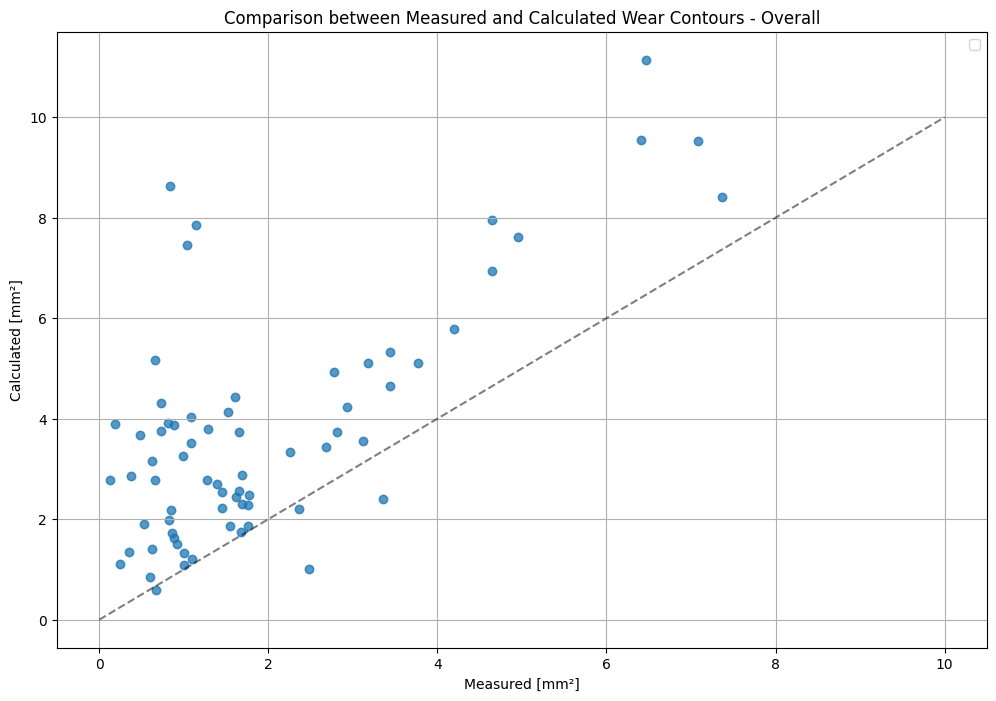

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours - Overall")
ax.scatter(np.array(measured_wear_area) * 1e6, np.array(calculated_wear_area) * 1e6, color='C0', alpha=0.5)
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]")
ax.set_xlabel("Measured [mm²]")

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_overall.pdf", bbox_inches='tight', dpi=300)

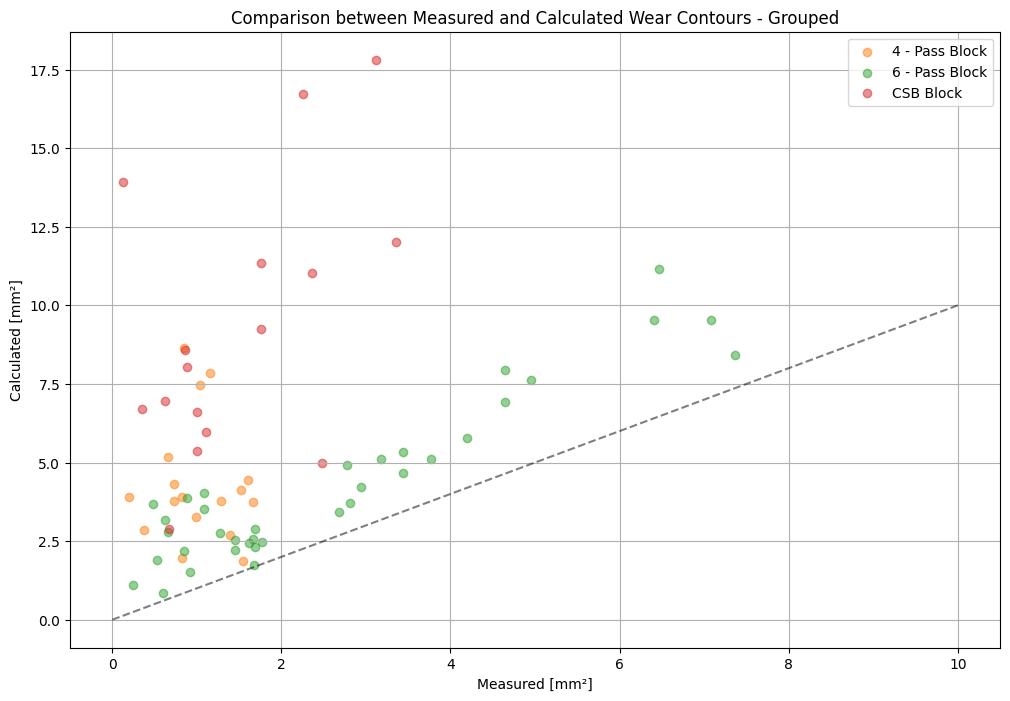

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours - Grouped")
ax.scatter(np.array(measured_wear_area_4_pass) * 1e6, np.array(calculated_wear_area_4_pass) * 1e6, color='C1', alpha=0.5, label="4 - Pass Block")
ax.scatter(np.array(measured_wear_area_6_pass) * 1e6, np.array(calculated_wear_area_6_pass) * 1e6, color='C2', alpha=0.5, label="6 - Pass Block")
ax.scatter(np.array(measured_wear_area_csb) * 1e6, np.array(calculated_wear_area_csb) * 1e6, color='C3', alpha=0.5, label="CSB Block")
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]")
ax.set_xlabel("Measured [mm²]")

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_per_block.pdf", bbox_inches='tight', dpi=300)

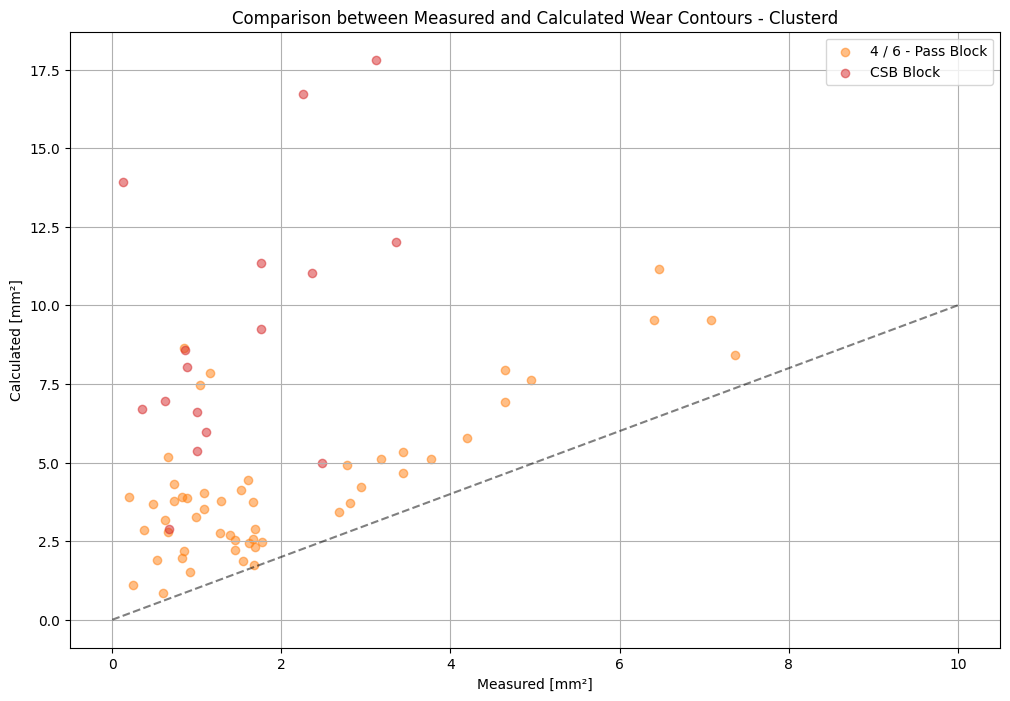

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours - Clusterd")
ax.scatter(np.array(measured_wear_area_4_and_6_pass) * 1e6, np.array(calculated_wear_area_4_and_6_pass) * 1e6, color='C1', alpha=0.5, label="4 / 6 - Pass Block")
ax.scatter(np.array(measured_wear_area_csb) * 1e6, np.array(calculated_wear_area_csb) * 1e6, color='C3', alpha=0.5, label="CSB Block")
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]")
ax.set_xlabel("Measured [mm²]")

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_for_clustering.pdf", bbox_inches='tight', dpi=300)